In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [2]:
# Discrete time model of a quadcopter
Ad = sparse.csc_matrix([
    [1.,      0.,     0., 0., 0., 0., 0.1,     0.,     0.,  0.,     0.,     0.],
    [0.,      1.,     0., 0., 0., 0., 0.,      0.1,    0.,  0.,     0.,     0.],
    [0.,      0.,     1., 0., 0., 0., 0.,      0.,     0.1, 0.,     0.,     0.],
    [0.0488,  0.,     0., 1., 0., 0., 0.0016,  0.,     0.,  0.0992, 0.,     0.],
    [0.,     -0.0488, 0., 0., 1., 0., 0.,     -0.0016, 0.,  0.,     0.0992, 0.],
    [0.,      0.,     0., 0., 0., 1., 0.,      0.,     0.,  0.,     0.,     0.0992],
    [0.,      0.,     0., 0., 0., 0., 1.,      0.,     0.,  0.,     0.,     0.],
    [0.,      0.,     0., 0., 0., 0., 0.,      1.,     0.,  0.,     0.,     0.],
    [0.,      0.,     0., 0., 0., 0., 0.,      0.,     1.,  0.,     0.,     0.],
    [0.9734,  0.,     0., 0., 0., 0., 0.0488,  0.,     0.,  0.9846, 0.,     0.],
    [0.,     -0.9734, 0., 0., 0., 0., 0.,     -0.0488, 0.,  0.,     0.9846, 0.],
    [0.,      0.,     0., 0., 0., 0., 0.,      0.,     0.,  0.,     0.,     0.9846]
])
Bd = sparse.csc_matrix([
    [0.,      -0.0726,  0.,     0.0726],
    [-0.0726,  0.,      0.0726, 0.],
    [-0.0152,  0.0152, -0.0152, 0.0152],
    [-0.,     -0.0006, -0.,     0.0006],
    [0.0006,   0.,     -0.0006, 0.0000],
    [0.0106,   0.0106,  0.0106, 0.0106],
    [0,       -1.4512,  0.,     1.4512],
    [-1.4512,  0.,      1.4512, 0.],
    [-0.3049,  0.3049, -0.3049, 0.3049],
    [-0.,     -0.0236,  0.,     0.0236],
    [0.0236,   0.,     -0.0236, 0.],
    [0.2107,   0.2107,  0.2107, 0.2107]])
[nx, nu] = Bd.shape

In [6]:
# Prediction horizon
N = 10
# Constraints
u0 = 10.5916
umin = 10.00 * np.ones(4) - u0
umax = 11.00 * np.ones(4) - u0
xmin = np.array([-np.pi/6, -np.pi/6, -np.inf, -np.inf, -np.inf, -1.,
                 -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
xmax = np.array([np.pi/6, np.pi/6, np.inf, np.inf, np.inf, np.inf,
                 np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

In [4]:
# Objective function
Q = sparse.diags([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.])
QN = Q
R = 0.1*sparse.eye(4)

In [5]:
# Initial and reference states
x0 = np.zeros(12)
xr = np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# Define problem
u = cp.Variable((nu, N))
x = cp.Variable((nx, N+1))
x_init = cp.Parameter(nx)
objective = 0
constraints = [x[:, 0] == x_init]
for k in range(N):
    objective += cp.quad_form(x[:, k] - xr, Q) + cp.quad_form(u[:, k], R)
    constraints += [x[:, k+1] == Ad @ x[:, k] + Bd @ u[:, k]]
    constraints += [xmin <= x[:, k], x[:, k] <= xmax]
    constraints += [umin <= u[:, k], u[:, k] <= umax]
objective += cp.quad_form(x[:, N] - xr, QN)
prob = cp.Problem(cp.Minimize(objective), constraints)

In [10]:
# Simulate in closed loop
nsim = 40
x_hist_high = [x0]
u_hist_high = []
x_hist_low = [x0]
u_hist_low = []

# High accuracy
np.random.seed(0)
x0 = np.zeros(12)
prob = cp.Problem(cp.Minimize(objective), constraints)
for i in range(nsim):
    x_init.value = x0
    prob.solve(solver=cp.OSQP, eps_abs=1e-04, eps_rel=1e-04, warm_start=True)
    x0 = Ad.dot(x0) + Bd.dot(u[:, 0].value) + 0.02*np.random.randn(len(x0))
    x_hist_high.append(x0)
    u_hist_high.append(u[:, 0].value)

# Low accuracy
np.random.seed(0)
x0 = np.zeros(12)
prob = cp.Problem(cp.Minimize(objective), constraints)
for i in range(nsim):
    x_init.value = x0
    prob.solve(solver=cp.OSQP, eps_abs=0.1, eps_rel=0.1, warm_start=True)
    x0 = Ad.dot(x0) + Bd.dot(u[:, 0].value) + 0.02*np.random.randn(len(x0))
    x_hist_low.append(x0)
    u_hist_low.append(u[:, 0].value)

z_pos_high = [s[2] for s in x_hist_high]
z_pos_low = [s[2] for s in x_hist_low]
t = range(nsim + 1) # Time vector

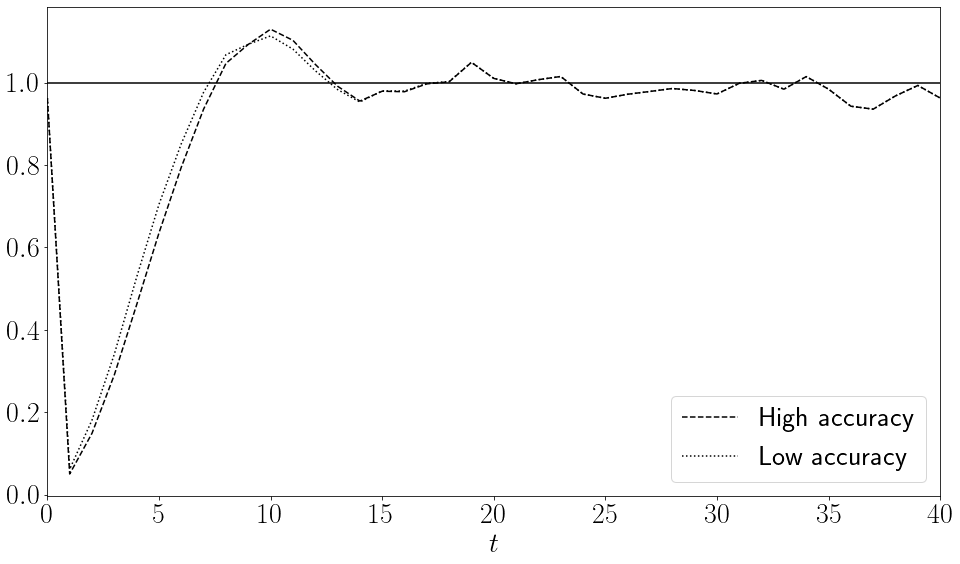

In [11]:
# Plot position
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(t, z_pos_high, label=r"High accuracy", color="k", linestyle="dashed")
ax.plot(t, z_pos_low, label=r"Low accuracy", color="k", linestyle="dotted")
ax.hlines(xr[2], t[0], t[-1], color='k')
ax.set_xlim([t[0], t[-1]])
ax.set_xlabel(r"$t$")
plt.legend()
plt.savefig('control_position.pdf')

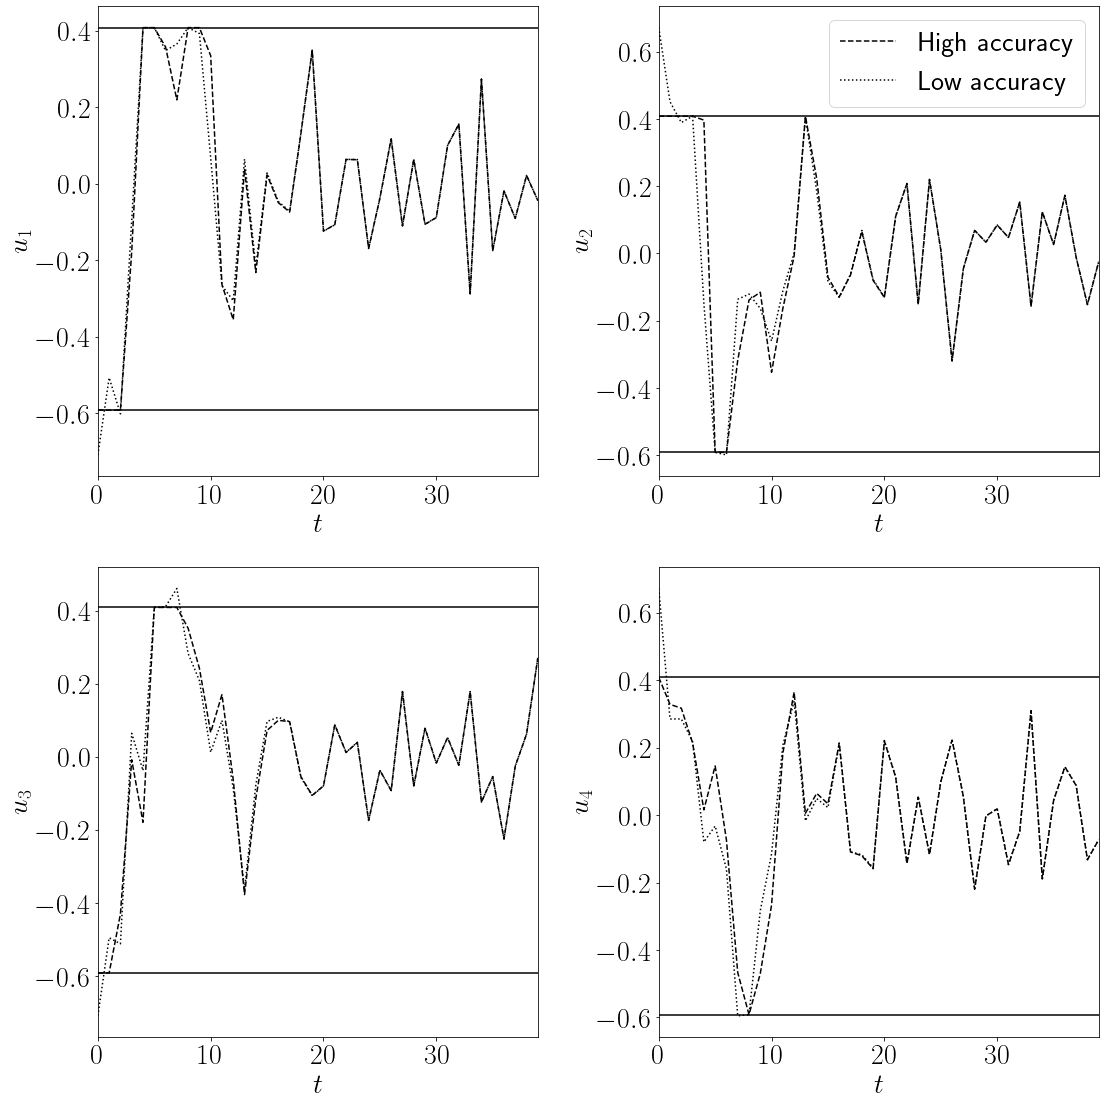

In [13]:
# Control effort
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
axs = ax.ravel()
t = range(nsim)
for i in range(4):
    ax = axs[i]
    u_i_high = [s[i] for s in u_hist_high]
    u_i_low = [s[i] for s in u_hist_low]
    ax.plot(t, u_i_high, label=r"High accuracy", color="k", linestyle="dashed")
    ax.plot(t, u_i_low, label=r"Low accuracy", color="k", linestyle="dotted")
    ax.hlines(umin[i], t[0], t[-1], color='k')
    ax.hlines(umax[i], t[0], t[-1], color='k')
    ax.set_xlim([t[0], t[-1]])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$u_%d$" % (i + 1))
    if i == 1:
        ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig('control_effort.pdf')